In [12]:
df[df['tourney_stats']!=df['tourney_stats']]

,tourney_id,tny_name,tourney_date,p0_name,p1_name,p0_elo,p1_elo,elo_diff,p0_s_elo,p1_s_elo,...,p0_52_rwon,p0_52_rpt,p1_52_rwon,p1_52_rpt,tourney_stats,best_of,score,pbp,winner,match_id
9756,2015-421,Canada Masters,2015-08-10,Pablo Cuevas,Thomaz Bellucci,1802.315171,1796.075430,6.239741,1606.386834,1583.120547,...,1397.0,3787.0,1364.0,3600.0,NaN,3,7-6 4-6 7-6,RSSRRSSS;SADSRRRSSA;ASSS;SASS;RSASA;SASS;DSRAS...,1,9756
9757,2015-421,Canada Masters,2015-08-10,Jack Sock,Adrian Mannarino,1873.567552,1744.173525,129.394027,1759.352011,1691.218789,...,1073.0,3135.0,1380.0,3726.0,NaN,3,6-2 2-6 7-6,SRSSS;RDRSD;ARSRAS;RRRSR;SDSRRSRSRSSS;SSSS;DRD...,0,9757
9758,2015-421,Canada Masters,2015-08-10,Grigor Dimitrov,Alexandr Dolgopolov,1942.705552,1840.657611,102.047941,1856.962474,1772.515264,...,1460.0,3902.0,1409.0,3711.0,NaN,3,6-4 7-5,RSSRRSARRSSRAS;DSSSS;SSRRRSRSRSSS;RSSSRS;SRSRS...,0,9758
9759,2015-421,Canada Masters,2015-08-10,Lukas Rosol,Kevin Anderson,1695.104440,1951.974704,-256.870265,1582.987013,1813.517418,...,987.0,2941.0,1565.0,4634.0,NaN,3,7-6 7-6,RSRSSS;RSRRAR;RSRSDSSRSS;ADRRSSRSRSAS;SSAS;SSD...,0,9759
9760,2015-421,Canada Masters,2015-08-10,Dominic Thiem,Ernests Gulbis,1848.269183,1690.996337,157.272847,1674.885663,1674.894171,...,1408.0,3963.0,866.0,2445.0,NaN,3,3-6 7-6 6-1,RSRSRSRSRARR;SASS;SARSDS;RRARSR;SRSRSS;SRSRRR;...,1,9760
9761,2015-421,Canada Masters,2015-08-10,Donald Young,Denis Kudla,1721.209555,1643.804580,77.404974,1722.091854,1509.440084,...,917.0,2606.0,535.0,1487.0,NaN,3,6-3 6-4,SSDRRSSS;ASSS;SSRRSS;SRSRAS;SSRAS;SSSS;SRRSSS;...,0,9761
9762,2015-421,Canada Masters,2015-08-10,Nick Kyrgios,Fernando Verdasco,1843.770181,1845.083049,-1.312868,1632.653657,1778.521517,...,838.0,2605.0,1435.0,3984.0,NaN,3,6-3 4-6 6-4,RRSRSSDASA;RSSSA;SSRSS;RSRSSRRR;SSRRDR;SSSRS;S...,0,9762
9763,2015-421,Canada Masters,2015-08-10,Vasek Pospisil,Yen Hsun,1828.012043,1736.385836,91.626207,1755.158404,1692.984376,...,1011.0,3176.0,852.0,2424.0,NaN,3,6-4 6-3,RSSRSS;SRRSSRRR;RRSSSS;DSSSRDRSSS;RSASA;SSSS;R...,0,9763
9764,2015-421,Canada Masters,2015-08-10,Benjamin Becker,John Isner,1645.407871,1964.019022,-318.611152,1587.226010,1946.602354,...,853.0,2615.0,1302.0,4472.0,NaN,3,6-4 6-7 6-3,SDSSS;SSSRS;SRRSSRSS;RARASRSA;RSSRRR;ASRRARSA;...,1,9764
9765,2015-421,Canada Masters,2015-08-10,Jeremy Chardy,Nicolas Mahut,1768.800627,1766.120575,2.680052,1712.223779,1584.372217,...,1297.0,3654.0,424.0,1192.0,NaN,3,6-1 7-5,SRAAA;RRSDR;SSSS;SSSS;SSRSS;SRRRR;SSAS.SRSSS;R...,0,9765


#new features: # total points won differential, 
last 10,20,30 points won differential
percent points won on serve, return so far
make number of sets completed as feature
export to csv

set up random forest testing...
figure out why adaboost is so high...

there are occasional errors in this dataset, like the last one
we'll assume that at least the last points of each game are correct, or nearly always correct

NOTE: I disabled sql database inserts in history.py, so it's not storing into history

In [1]:
# TO DO: test all dataframes with logistic regression, random forest, neural net, everything else
# in the sklearn toolkit; redo test,train,split by match
from ast import literal_eval
from collections import Counter
import pandas as pd
import numpy as np
import math
from helper_functions import *
import time

df = pd.read_csv('../my_data/elo_pbp_with_surface_8_14.csv')
del df['Unnamed: 0']

# append . to end of pbp string to signify end of match if not marked '0' means player0 won;
# '1' means player1 won (originally player1, player2); small fix for dead rubbers
df['pbp'] = [s + '.' if s[-1]!= '.' else s for s in df['pbp']]
df.rename(columns={'tourney_name':'tny_name'},inplace=True)
df['tny_name'] = [df['tny_name'][i]+' (3)' if df['tny_name'][i]=='Davis Cup' and \
                  df['best_of'][i]==3 else df['tny_name'][i] for i in xrange(len(df))]
df['match_id'] = range(len(df))
df.head(2)

,tourney_id,tny_name,tourney_date,p0_name,p1_name,p0_elo,p1_elo,elo_diff,p0_s_elo,p1_s_elo,...,p0_52_rwon,p0_52_rpt,p1_52_rwon,p1_52_rpt,tourney_stats,best_of,score,pbp,winner,match_id
0,2010-375,Montpellier,2010-10-25,Romain Jouan,Taylor Dent,1519.128216,1720.828131,-201.699915,1517.563000,1669.753884,...,38.0,116.0,750.0,2182.0,0.66189,3,6-7 6-3 6-4,SSSS;SSSS;SSSS;SSSS;SSSS;SRRSSS;RRSSRSSS;SSSS;...,1,0
1,2010-375,Montpellier,2010-10-25,Julian Reister,Richard Gasquet,1574.319533,1948.840391,-374.520858,1472.470266,1839.154165,...,330.0,933.0,1624.0,4348.0,0.66189,3,6-7 6-3 6-3,SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;SSRRSR...,1,1


In [2]:
# split this df into best-of-three and best-of-five matches
gs_tourneys = ['Australian Open', 'Davis Cup', 'Roland Garros', 'US Open', 'Wimbledon']
df_pbp3 = df[~df['tny_name'].isin(gs_tourneys)]
df_pbp5 = df[df['tny_name'].isin(gs_tourneys)]
df_pbp3=df_pbp3.reset_index();df_pbp5=df_pbp5.reset_index()
del df_pbp3['index']; del df_pbp5['index']

final_set_d = Counter()
for gs in gs_tourneys: final_set_d[gs]=1 if gs!='US Open' else 0

In [3]:
# note also: the player with higher elo serves first 54% of the time
# interesting that it's this high for the first server in best-of-five...
print 'player who serves first wins in best-of-three: ' + str(100*round(len(df_pbp3[df_pbp3['winner']==0])/float(len(df_pbp3)),3)) + '%'
print 'player who serves first wins in best-of-five: ' + str(100*round(len(df_pbp5[df_pbp5['winner']==0])/float(len(df_pbp5)),3)) + '%'

player who serves first wins in best-of-three: 52.7%
player who serves first wins in best-of-five: 54.5%


In [4]:
set_order_d = dict(zip(range(len(df)),[get_set_order(df['pbp'][i]) for i in xrange(len(df))]))

start = time.clock()
cols = ['match_id','elo_diff','s_elo_diff','winner','p0_52_swon','p0_52_svpt','p1_52_swon','p1_52_svpt',\
        'p0_52_rwon','p0_52_rpt','p1_52_rwon','p1_52_rpt', 'tourney_stats','best_of']
df_pred = generate_df_2(df_pbp3,cols,0)
print 'time: ', time.clock()-start

time:  11.145075


In [5]:
breaks = [0]*len(df_pred)
for i in xrange(len(df_pred)):
    breaks[i] = break_point(df_pred['score'][i])
df_pred['up_break_point'] = [a[0] for a in breaks]
df_pred['down_break_point'] = [a[1] for a in breaks]
df_pred['break_adv'] = [service_breaks(df_pred['score'][i]) for i in xrange(len(df_pred))]

In [6]:
df_pred.shape

(1230545, 31)

In [8]:
# exporting to csv rescues the correct data type for each column (which somehow all got
# converted to string in my enumerate() function)

# YASSSS!!!
#df_pred.to_csv('../my_data/feature_df_pbp3_8_14.csv')

In [9]:
# so...20% of all points in tennis are break points? wouldn't seem like that from the first 
# match (there are hardly any service breaks). Worth a mention/second look...
print len(df_pred[df_pred['up_break_point']==1])/float(len(df_pred))
print len(df_pred[df_pred['down_break_point']==1])/float(len(df_pred))

0.0987253615268
0.101177933355


In [136]:
df_pred['0'] = [int(df_pred['set_diff'][i]==1)]
df_pred['1'] = [int(df_pred['set_diff'][i]==-1)]
df_pred['01'] = [int(df_pred['set_score'][i]==[0,1])]
df_pred['10'] = [int(df_pred['set_score'][i]==[0,1])]

TypeError: cannot convert the series to <type 'int'>

In [31]:
# TO DO: for now, just say test is the 20% most recent matches
c = int(len(df)*.8)
df_pred['train'] = [1 if df_pred['match_id'][i] <= c else 0 for i in xrange(len(df_pred))]
mask = df_pred['train']
mask = mask==1
# can also randomize later if you want...

y = df_pred['winner']
ytrain=y[mask]
ytest=y[~mask]

In [41]:
# to do: set up another notebook with solely cross-validation framework and model testing...
# test hyperparameters for these sklearn models
cols = []
cols.append(['elo_diff','set_diff','game_diff','point_diff'])
cols.append(['elo_diff','set_diff','break_adv','point_diff'])
cols.append(['elo_diff','set_diff','game_diff','point_diff','break_adv'])

for col in cols:
    Xtrain = df_pred[mask][col]; Xtest = df_pred[~mask][col]
    clf = linear_model.LogisticRegression(fit_intercept = True)
    clf.fit(Xtrain,ytrain)

    probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
    train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
    train_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print 'cols: ',col
    print 'classifier: ', clf
    print train_loss, test_loss
    print train_accuracy, test_accuracy

cols:  ['elo_diff', 'set_diff', 'game_diff', 'point_diff']
0.487115344533 0.501355894087
0.761507140592 0.750605088371
cols:  ['elo_diff', 'set_diff', 'break_adv', 'point_diff']
0.488017981414 0.503220617021
0.759540518447 0.749033734849
cols:  ['elo_diff', 'set_diff', 'game_diff', 'point_diff', 'break_adv']
0.484903036576 0.499306684439
0.762518929157 0.751463469549


In [16]:
# Now, we'll visualize the win probability over the course of a given match, such as 
# the first one between Julian Reister vs Richard Gasquet

/Users/jacobgollub/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


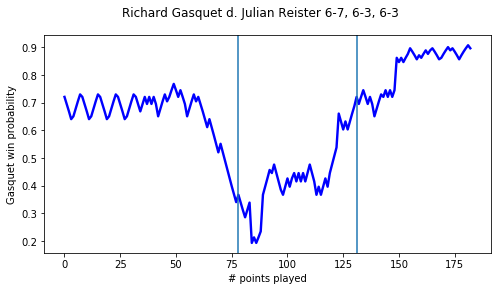

In [42]:
# graphically, try to compare different probabilities of different models

import matplotlib.pyplot as plt
%matplotlib inline

probs = np.concatenate((probs_train[:,0],probs_test[:,0]))
df_pred['prob4'] = probs

match1 = df_pred[df_pred['match_id']==0]
m1_probs = match1['prob4']
set_lengths = [len(a) for a in list(match1['current_score'])[-1].replace(';','').replace('/','').split('.')]
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m1_probs)),1-m1_probs,'b-',linewidth=2.4)
fig.suptitle('Richard Gasquet d. Julian Reister 6-7, 6-3, 6-3')
ax.set_ylabel('Gasquet win probability')
ax.set_xlabel('# points played')
ax.axvline(set_lengths[0]); ax.axvline(sum(set_lengths[:2]))
fig.show()

One main problem we can see with this graph is that it seems too sensitive to service holds. The win probability should not shift back and forth 10% after each service hold in the opener. Also, because differentials do not tell us the point in match, or how close we are to conclusion, the win probability never passes 90%, even when Gasquet is at match point. However, I will continue to explore features, next adding service break advantage as a feature. Then, explore features that tell you how close the set is to over (maybe games required to win the set??) and momentum over recent points/games. How often do people win tiebreaks after giving up a break advantage?

In [1]:
# two indicator variables
# (although, ultimately we want a probability of winning the current game from score)
# actually, we want to combine everything into one function that will get
# set score, game score, service breaks, break point indicator            
    

def down_break_point(s):
    
    return

In [ ]:
cols1 = ['elo_diff']
cols2 = ['elo_diff','set_diff']
cols3 = ['elo_diff','set_diff','game_diff']
cols = ['elo_diff','set_diff','game_diff','point_diff']

In [98]:
# either change do-classify to work for all classifiers or use this code
# repeat this for random forest, neural net, adaboost, etc
print 'features: ', cols
clf = ensemble.RandomForestClassifier(n_estimators=10,max_features=None,oob_score=True)
clf=clf.fit(Xtrain, ytrain)
probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
train_accuracy = clf.oob_score_
#test_accuracy = clf.oob_score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (train_accuracy)
print "Log Loss on training data: %0.2f" % (train_loss)
#print "Accuracy on test data:     %0.2f" % (test_accuracy)
print "Log Loss on test data:     %0.2f" % (test_loss)

features:  ['elo_diff', 'set_diff', 'game_diff', 'point_diff']
############# based on standard predict ################
Accuracy on training data: 1.00
Log Loss on training data: 0.00
Log Loss on test data:     7.44


In [35]:
# next, 1) compare avg log_loss for prediction with sets, games, and points as features
# 2) then try keeping track of service breaks as a feature
# 3) the next step: does order matter?
# see your notes for next steps

probs = clflogELO.predict_proba(Xtest)
log_loss(ytest,probs,labels=[0,1])

0.5434447917276245

In [ ]:
# def break_point(s):
#     s=s.replace('A','S');s=s.replace('D','R')
#     all_sets = s.split('.')
#     for k in range(len(all_sets)):
#         # set server to 0 or 1 at beginning of set, keeping track of all transitions
#         server = 0 if k==0 else next_server 
#         games = all_sets[k].split(';')
#         length = len(games)
#         next_server = (server+1)%2 if length>12 else (server + length)%2   
#         if k==len(all_sets)-1:
#             last_game = games[-1]
#             final_server = (server+len(games[:-1]))%2
#             pt_s,pt_r = last_game.count('S'),last_game.count('R')
#             b_point = pt_r+1>=4 and pt_r+1>=pt_s
#             #print b_point
#             #print pt_s,pt_r
#             if b_point and final_server:
#                 return (1,0)
#             elif b_point and not final_server:
#                 return (0,1)
#             else:
#                 return (0,0)